In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [152]:
# TODO:
# - Store timestamps
# - Store constants
#X = np.load('convection.npy')

#X = np.loadtxt('opencl/output.csv', delimiter=';')
X = np.array(pd.read_csv('opencl/output.csv', delimiter=';', header=None))
X = X.reshape(X.shape[0], X.shape[1] / 4, 4)
GRAVITY = -10.0

print X.shape
dt = 0.001;
T = np.array(range(X.shape[0])) * dt;

C = np.loadtxt('opencl/dissipation.csv', delimiter=';')
print C.shape

(1001, 2048, 4)
(1001, 2)


In [153]:
kinetic_energy = 0.5 * np.sum(X[:, :, 2:4] * X[:, :, 2:4], axis=2)
total_kinetic_energy = np.sum(kinetic_energy, axis=1)

gravitational_potential_energy = -GRAVITY * X[:, :, 1]
total_gravitational_potential_energy = np.sum(gravitational_potential_energy, axis=1)

total_cumulative_kinetic_energy_input = C[:, 1]
total_cumulative_kinetic_energy_dissipated = C[:, 0]

Initial total energy:  671.51188047


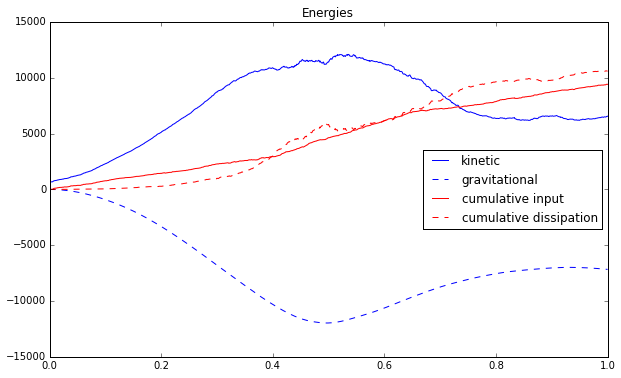

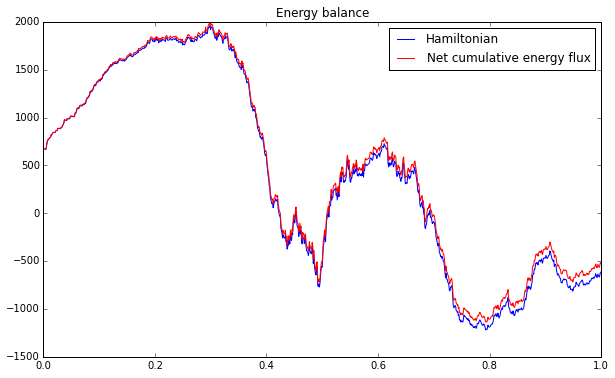

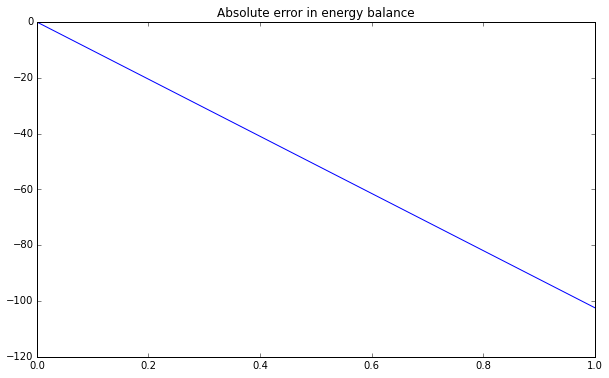

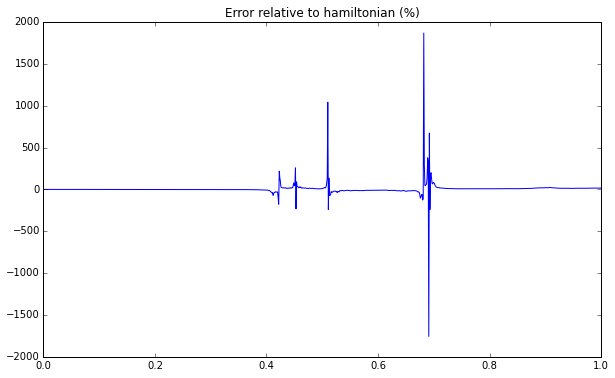

In [154]:
# Energy balance
# 0.5 mv^2 + mgh = E_in_accumulated - E_out_accumulated + Hamiltonian_at_0
# where E_in is the part of the kinetic energy that comes from the lower bound
# i.e. 0.5 mv_after^2 - 0.5 mv_before^2 = 0.5 m(v_after^2 - v_before^2)

# Notes:
# Energy balance are not perfect because of the limited precision when accumulating in floats
# Accumulators are used for each step in between dtSampling, and for each particles in the case of multiple collisions
# Also the floating point precision is not enough to store the result of the integration so gravitational energy might be lost/gained..

H0 = total_kinetic_energy[0] + total_gravitational_potential_energy[0]
print 'Initial total energy: ', H0

plt.figure(figsize=(10, 6))
plt.title('Energies')
plt.plot(T, total_kinetic_energy, 'b')
plt.plot(T, total_gravitational_potential_energy, '--b')
plt.plot(T, total_cumulative_kinetic_energy_input, 'r')
plt.plot(T, total_cumulative_kinetic_energy_dissipated, '--r')
plt.legend(['kinetic', 'gravitational', 'cumulative input', 'cumulative dissipation'], loc=0)

plt.figure(figsize=(10, 6))
plt.title('Energy balance')
plt.plot(T, total_kinetic_energy + total_gravitational_potential_energy)
plt.plot(T, total_cumulative_kinetic_energy_input - total_cumulative_kinetic_energy_dissipated + total_kinetic_energy[0] + total_gravitational_potential_energy[0], 'r')
plt.legend(['Hamiltonian', 'Net cumulative energy flux'], loc=0)

plt.figure(figsize=(10, 6))
plt.title('Absolute error in energy balance')
plt.plot(T, total_kinetic_energy + total_gravitational_potential_energy \
         - total_cumulative_kinetic_energy_input + total_cumulative_kinetic_energy_dissipated \
         - total_kinetic_energy[0] - total_gravitational_potential_energy[0])

plt.figure(figsize=(10, 6))
plt.title('Error relative to hamiltonian (%)')
plt.plot(T, 100.0 / (total_kinetic_energy + total_gravitational_potential_energy) * (total_kinetic_energy + total_gravitational_potential_energy \
         - total_cumulative_kinetic_energy_input + total_cumulative_kinetic_energy_dissipated \
         - total_kinetic_energy[0] - total_gravitational_potential_energy[0]))

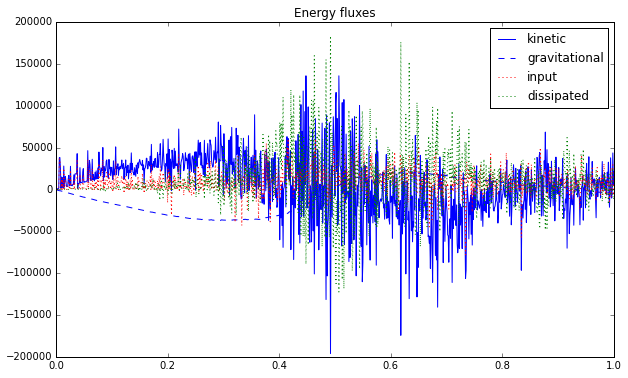

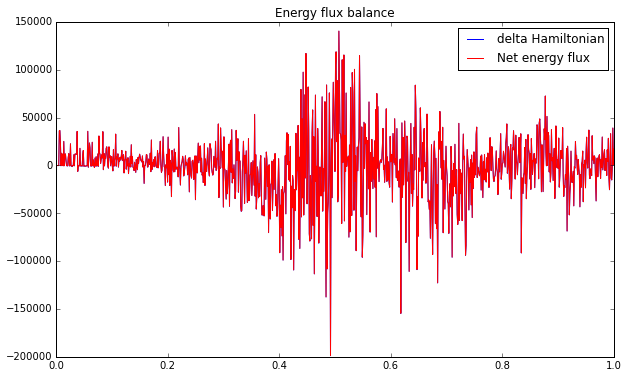

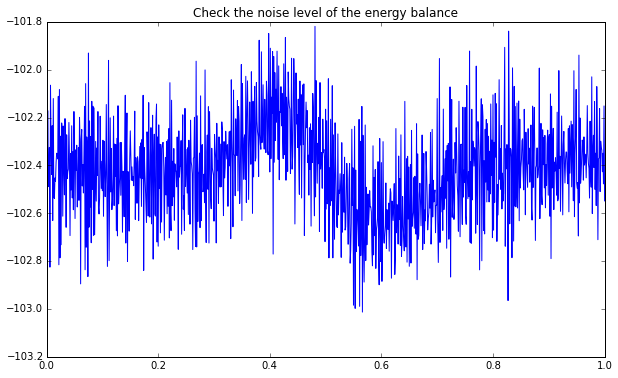

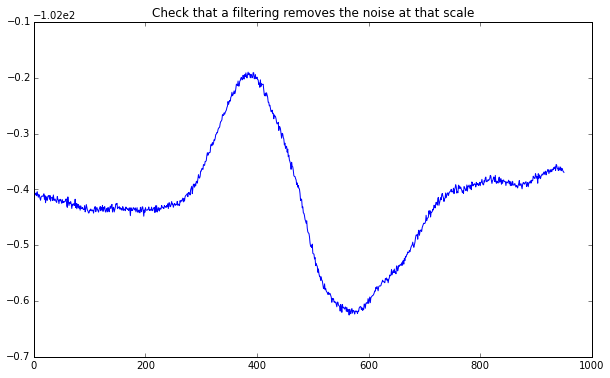

In [155]:
# Energy flux balance
# d/dt(Hamiltonian) - E_in + E_out = 0
plt.figure(figsize=(10, 6))
plt.title('Energy fluxes')
plt.plot(T[1:], np.diff(total_kinetic_energy) / dt, 'b')
plt.plot(T[1:], np.diff(total_gravitational_potential_energy) / dt, '--b')
plt.plot(T[1:], np.diff(total_cumulative_kinetic_energy_input) / dt, ':r')
plt.plot(T[1:], np.diff(total_cumulative_kinetic_energy_dissipated) / dt, ':g')
plt.legend(['kinetic', 'gravitational', 'input', 'dissipated'], loc=0)

plt.figure(figsize=(10, 6))
plt.title('Energy flux balance')
plt.plot(T[1:], np.diff(total_kinetic_energy + total_gravitational_potential_energy) / dt)
plt.plot(T[1:], np.diff(total_cumulative_kinetic_energy_input - total_cumulative_kinetic_energy_dissipated) / dt, 'r')
plt.legend(['delta Hamiltonian', 'Net energy flux'], loc=0)

D = 1.0 / dt * ( \
       np.diff(total_kinetic_energy + total_gravitational_potential_energy) \
     - np.diff(total_cumulative_kinetic_energy_input) \
     + np.diff(total_cumulative_kinetic_energy_dissipated))
plt.figure(figsize=(10, 6))
plt.title('Check the noise level of the energy balance')
plt.plot(T[1:], D)

def moving_average(a, n=3) :
    tmp = a.copy()
    tmp[~np.isfinite(tmp)] = 0
    tmp = np.cumsum(tmp)
    tmp[n:] = tmp[n:] - tmp[:-n]
    return tmp[n - 1:] / n

plt.figure(figsize=(10, 6))
plt.title('Check that a filtering removes the noise at that scale')
n=50; plt.plot(moving_average(D, n))
#ax2 = plt.gca().twinx(); ax2.plot(np.diff(total_kinetic_energy))

Note that the trend after the noise filtering is the integration error that depends on the hamiltonian itself (it shouldn't however depend on time).

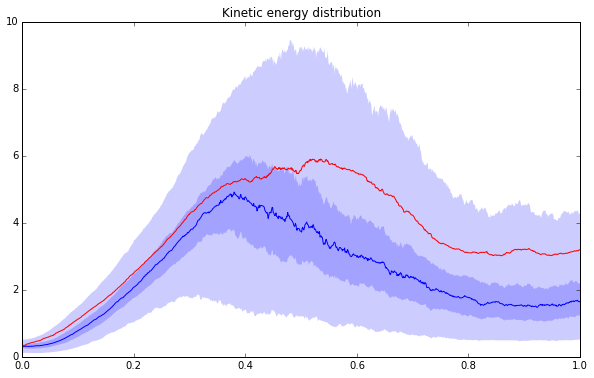

In [156]:
p = 0.8
plt.figure(figsize=(10, 6))
plt.fill_between(T, np.percentile(kinetic_energy, 100 - p*100, axis=1), np.percentile(kinetic_energy, p*100, axis=1), alpha=0.2, linewidth=0)
plt.fill_between(T, np.percentile(kinetic_energy, 100 - p/2*100, axis=1), np.percentile(kinetic_energy, p/2*100, axis=1), alpha=0.2, linewidth=0)
plt.plot(T, np.median(kinetic_energy, axis=1))
plt.plot(T, np.mean(kinetic_energy, axis=1), '-r')
plt.plot([T[0], T[-1]], [0, 0], ':k')
plt.title('Kinetic energy distribution')

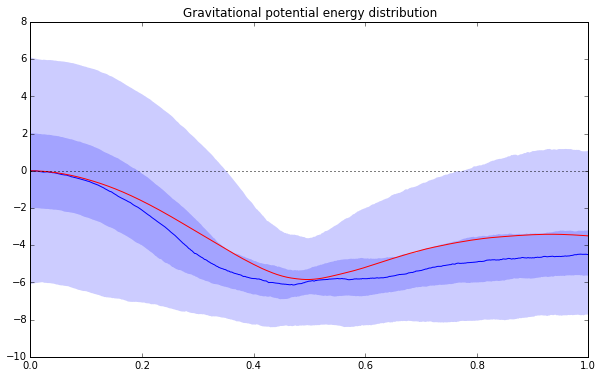

In [157]:
p = 0.8
plt.figure(figsize=(10, 6))
plt.fill_between(T, np.percentile(gravitational_potential_energy, 100 - p*100, axis=1), np.percentile(gravitational_potential_energy, p*100, axis=1), alpha=0.2, linewidth=0)
plt.fill_between(T, np.percentile(gravitational_potential_energy, 100 - p/2*100, axis=1), np.percentile(gravitational_potential_energy, p/2*100, axis=1), alpha=0.2, linewidth=0)
plt.plot(T, np.median(gravitational_potential_energy, axis=1))
plt.plot(T, np.mean(gravitational_potential_energy, axis=1), '-r')
plt.plot([T[0], T[-1]], [0, 0], ':k')
plt.title('Gravitational potential energy distribution')

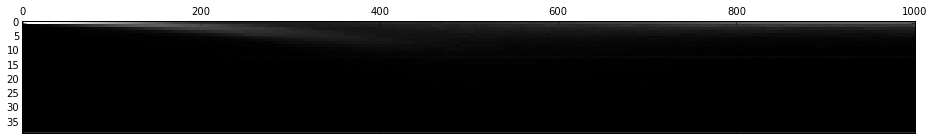

In [158]:
# THE PREVIOUS PLOTS ASSUMES UNIMODALITY. WE NEED TO SHOW A BETTER PLOT!!!

plt.figure(figsize=(10,6))
bins = range(40)
D = np.zeros(shape=(len(T),len(bins) - 1))
for i in range(len(T)):
    d, _ = np.histogram(kinetic_energy[i, :], bins=bins, density=True)
    D[i, :] = d
plt.matshow(D.T, interpolation='none', aspect='auto', cmap=plt.cm.gray)
#plt.yticks(range(len(bins)), bins)

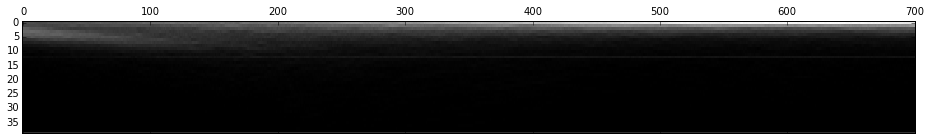

In [159]:
# Show after 300
plt.matshow(D.T[:, 300:], interpolation='none', aspect='auto', cmap=plt.cm.gray)

The system seems to have forgotten about initial conditions around t = 400.
The bright spot appears no matter the t0 we take. It hints at a growing energy accumulation resulting in a growing tail and a lowering of the mode as time progresses.

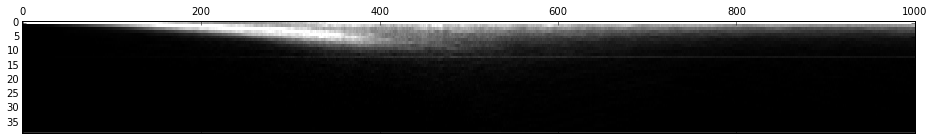

In [160]:
# Here we show unnormalized histograms. This means the color is not anymore the proba: we can only compare colors at same time.
plt.figure(figsize=(10,6))
Dn = D.copy()
for i in range(len(T)):
    Dn[i, :] = D[i, :]/np.max(D[i, :]) # Rescales
plt.matshow(Dn.T, interpolation='none', aspect='auto', cmap=plt.cm.gray)

(None, <matplotlib.text.Text at 0x11c9a4450>)

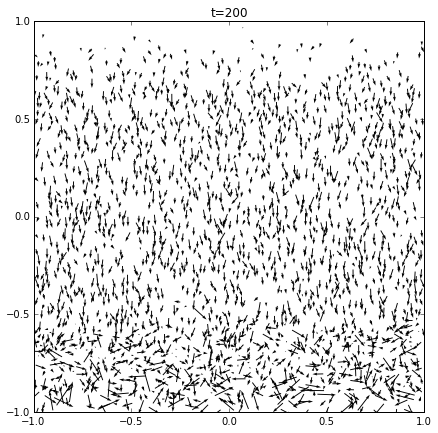

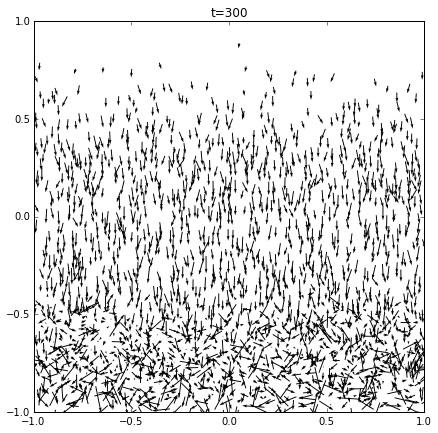

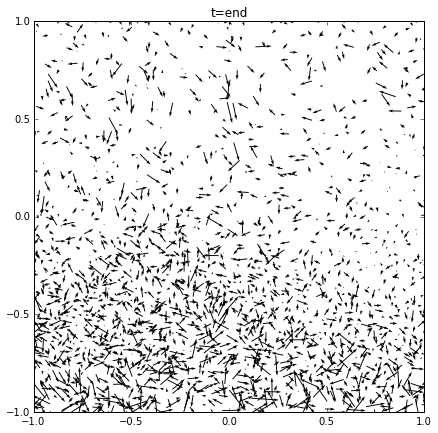

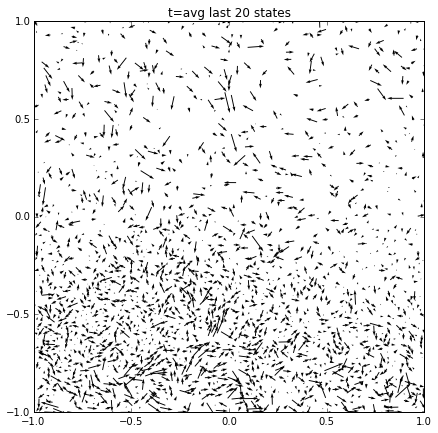

In [161]:
def plot_state(x):
    plt.figure(figsize=(7,7))
    plt.subplot(aspect='equal')
    #plt.scatter(x=x[:, 0], y=x[:, 1], c=np.linalg.norm(x[:, 2:4], axis=1), s=5, lw=0.3, cmap=plt.get_cmap('Reds'))
    plt.quiver(x[:, 0], x[:, 1], x[:, 2], x[:, 3], scale=100)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
t=200; plot_state(X[t]), plt.title('t=%d' % t)
t=300; plot_state(X[t]), plt.title('t=%d' % t)
plot_state(X[-1]), plt.title('t=end')
plot_state(np.mean(X[-20:, :, :], axis=0)), plt.title('t=avg last 20 states')

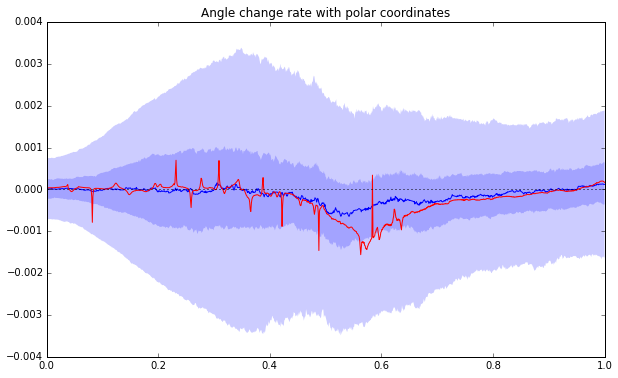

In [162]:
# Try with polar coordinates
p = 0.8
theta = np.arctan2(X[:, :, 1], X[:, :, 0])
theta_dot = np.mod(np.diff(theta, axis=0) + np.pi, 2*np.pi) - np.pi
plt.figure(figsize=(10, 6))
plt.fill_between(T[1:], np.percentile(theta_dot, 100 - p*100, axis=1), np.percentile(theta_dot, p*100, axis=1), alpha=0.2, linewidth=0)
plt.fill_between(T[1:], np.percentile(theta_dot, 100 - p/2*100, axis=1), np.percentile(theta_dot, p/2*100, axis=1), alpha=0.2, linewidth=0)
plt.plot(T[1:], np.median(theta_dot, axis=1))
plt.plot(T[1:], np.mean(theta_dot, axis=1), '-r')
plt.plot([T[0], T[-1]], [0, 0], ':k')
plt.title('Angle change rate with polar coordinates')

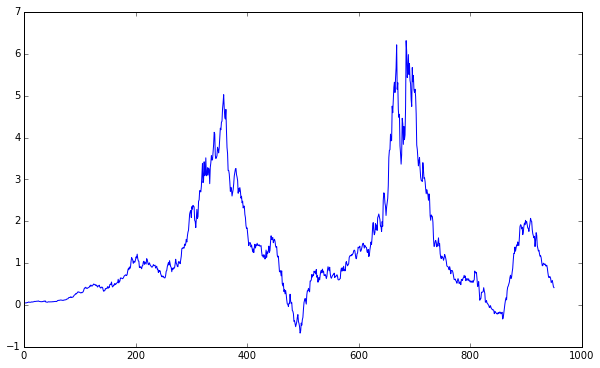

In [163]:
# Check stationarity of signal
w = 50 # Use the window to remove the noise from the rounding errors (we known energy conservation is valid up to that point)
dissipation_ratio = moving_average(np.diff(total_cumulative_kinetic_energy_dissipated), w) / \
    moving_average(np.diff(total_cumulative_kinetic_energy_input), w)
plt.figure(figsize=(10, 6))
plt.plot(dissipation_ratio)

In [164]:
Y = X[0, :, :].copy()
Y[:, 0] += Y[:, 2]*dt + GRAVITY*0.5*dt*dt
Y[:, 1] += Y[:, 3]*dt
Y[:, 3] += GRAVITY*dt
print 'error T', total_kinetic_energy[1] - np.sum(0.5*(Y[:,2]*Y[:,2] + Y[:,3]*Y[:,3]))
print 'error V', total_gravitational_potential_energy[1] - (-GRAVITY * np.sum(Y[:,1]))
print 'mean state error (gpu float vs python double)', np.mean(Y[:,0] - X[1, :, 0]), np.mean(Y[:,1] - X[1, :, 1]), np.mean(Y[:,2] - X[1, :, 2]), np.mean(Y[:,3] - X[1, :, 3])

error T -2.76457114978e-06
error V -0.204954899987
mean state error (gpu float vs python double) -5.00523095703e-06 1.00075634766e-05 0.0 -5.85937500783e-09


-0.53937
-0.3344151
1.00075634766e-05 2.94075447832e-07 0.2049549
error 0.2049549


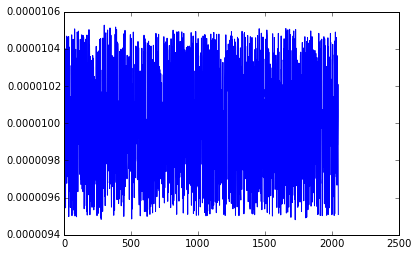

In [165]:
print -GRAVITY * np.sum(X[1, :, 1])
print -GRAVITY * np.sum(Y[:, 1])
e = Y[:,1] - X[1, :, 1]
plt.plot(e)
print np.mean(e), np.std(e), np.mean(e)*2048*10
print 'error', -GRAVITY * np.sum(Y[:,1] - X[1, :, 1])